<a href="https://colab.research.google.com/github/khushidubeyokok/BERTopic/blob/main/2_Title_vs_Abstract_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Title vs. Abstract Analysis  
This notebook explores the relationship between topics derived from research paper titles and their abstracts using BERTopic. Our goal is to analyze the degree to which paper **titles** reflect the content of their **abstracts**, and identify any gaps or alignment between them.


##Data Source:
We will apply BERTopic to the **[neuralwork/arxiver](https://huggingface.co/datasets/neuralwork/arxiver)** dataset available from Hugging Face.This dataset contains abstracts and titles of research papers across various domains, making it ideal for topic modeling analysis.

### Objectives:
1. **Topic Analysis**: Investigate whether research paper titles contain meaningful information about their corresponding abstracts.
2. **Comparative Analysis**: Explore the topic distributions in titles and abstracts, providing deeper insights into how topics are represented across these two sections.
3. **Data-Driven Insights**: Offer suggestions for improving title and abstract alignment in academic writing.

By the end of this notebook, we'll have generated insightful visualizations and a robust correlation analysis to validate the relationship between research paper titles and their abstracts. We aim to deliver actionable recommendations for improving the clarity and accuracy of academic titles and abstracts.

Let’s dive in! 🚀


## 🛠️ Step 1: Load Essential Libraries  
To kick things off, we’ll import the necessary Python libraries, including BERTopic for topic modeling and data manipulation tools like Pandas.

In [ ]:
# Install Necessary Packages
!pip -q install datasets
!pip -q install bertopic
!pip -q install transformers
!pip -q install umap-learn hdbscan
!pip install sentence-transformers

# Import Libraries
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd

# Download Necessary NLTK Resources
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###Preprocessing Function
This section defines a robust preprocessing function to clean and prepare the textual data. The process includes:

- Converting text to lowercase
- Removing numbers and special characters
- Removing stopwords
- Lemmatizing words

These steps ensure the data is clean and consistent for further analysis.

In [ ]:
def preprocess_text(text):
    """Preprocesses the input text by lowercasing, removing numbers, special characters, stopwords, and lemmatizing."""
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    words = text.split()
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


 ## 📂 Step 2: Load and preprocess data
We use the neuralwork/arxiver dataset from the datasets library, which provides titles and abstracts of research papers. This data forms the basis for our analysis.

In [ ]:
dataset = load_dataset("neuralwork/arxiver")
processed_titles = [preprocess_text(title) for title in dataset['train']['title']]
processed_abstracts = [preprocess_text(abstract) for abstract in dataset['train']['abstract']]

## 🤖 Step 3: Define and Fit BERTopic Models
This section explains the BERTopic modeling process:

Separate models for titles and abstracts are defined.
Models are configured with custom UMAP and HDBSCAN parameters for dimensionality reduction and clustering.
Each model identifies meaningful topics within the data.


In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Define and Fit BERTopic Models
topic_model_titles = BERTopic(
    embedding_model=embedding_model,
    umap_model=UMAP(n_neighbors=10, n_components=5, min_dist=0.1, metric='cosine'),
    hdbscan_model=HDBSCAN(min_cluster_size=60, min_samples=15, metric='euclidean', cluster_selection_method='eom'),
    top_n_words=10
)

topic_model_abstracts = BERTopic(
    embedding_model=embedding_model,
    umap_model=UMAP(n_neighbors=10, n_components=5, min_dist=0.1, metric='cosine'),
    hdbscan_model=HDBSCAN(min_cluster_size=60, min_samples=15, metric='euclidean', cluster_selection_method='eom'),
    top_n_words=10
)

# Fit Models
topics_titles, probs_titles = topic_model_titles.fit_transform(processed_titles)
topics_abstracts, probs_abstracts = topic_model_abstracts.fit_transform(processed_abstracts)


In [ ]:
# Visualize top words per topic for titles
topic_model_titles.visualize_barchart(top_n_topics=4).show()

# Visualize top words per topic for abstracts
topic_model_abstracts.visualize_barchart(top_n_topics=4).show()


In [ ]:
# Visualize topic clusters for titles
topic_model_titles.visualize_topics().show()

# Visualize topic clusters for abstracts
topic_model_abstracts.visualize_topics().show()


## 🔍 Step 4: Title vs. Abstract Analysis

Now that we have topics assigned to both titles and abstracts, we can begin comparing them.
- Firstly we extract the most representative words for each identified topic.
- Then we generate vectors for each topic based on its representative words using the SentenceTransformer embeddings. These vectors enable similarity computations.
-  Finally we calculate the cosine similarity matrix between title and abstract topic vectors to quantify their semantic alignment.

In [ ]:
def get_topic_words(topic_model, topics):
    return {topic: topic_model.get_topic(topic) for topic in set(topics) if topic != -1}

title_topic_words = get_topic_words(topic_model_titles, topics_titles)
abstract_topic_words = get_topic_words(topic_model_abstracts, topics_abstracts)

# Generate Topic Vectors
def get_topic_vector(words):
    """Generates a vector for a topic based on its words."""
    if not words:
        return embedding_model.encode("")  # Handle empty topics
    words_only = [word for word, _ in words]
    return embedding_model.encode(' '.join(words_only))

title_vectors = {i: get_topic_vector(words) for i, words in title_topic_words.items()}
abstract_vectors = {i: get_topic_vector(words) for i, words in abstract_topic_words.items()}

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(
    list(title_vectors.values()),
    list(abstract_vectors.values())
)

## 📊 Step 5: Visualize
- Here, we compile the title, abstract, topic numbers, topic words, and similarity scores into a comprehensive DataFrame for easy interpretation and visualization.
- To ensure accuracy, we filter out NaN values representing topics that were not assigned during modeling (outliers).




In [ ]:
data = []

for i in range(len(dataset['train'])):
    title = dataset['train'][i]['title']
    abstract = dataset['train'][i]['abstract']
    title_topic = topics_titles[i]
    abstract_topic = topics_abstracts[i]

    title_words = title_topic_words.get(title_topic, [])
    abstract_words = abstract_topic_words.get(abstract_topic, [])

    if title_topic != -1 and abstract_topic != -1:
        similarity_score = similarity_matrix[title_topic, abstract_topic]
    else:
        similarity_score = None  # Handle unassigned topics

    data.append({
        "Title": title,
        "Abstract": abstract,
        "Title Topic": title_topic,
        "Abstract Topic": abstract_topic,
        "Title Topic Words": title_words,
        "Abstract Topic Words": abstract_words,
        "Similarity": similarity_score
    })

df_similarity = pd.DataFrame(data)

# Display Results
print(df_similarity.head())
display(df_similarity)

                                               Title  \
0  Image Completion via Dual-path Cooperative Fil...   
1  High Sensitivity Beamformed Observations of th...   
2  Maybe, Maybe Not: A Survey on Uncertainty in V...   
3  Enhancing GAN-Based Vocoders with Contrastive ...   
4      Nonvolatile Magneto-Thermal Switching in MgB2   

                                            Abstract  Title Topic  \
0  Given the recent advances with image-generatin...           -1   
1  We analyzed four epochs of beamformed EVN data...           92   
2  Understanding and evaluating uncertainty play ...           -1   
3  Vocoder models have recently achieved substant...          103   
4  Ongoing research explores thermal switching ma...            2   

   Abstract Topic                                  Title Topic Words  \
0              -1                                                 []   
1               0  [(pulsar, 0.3876325764430906), (timing, 0.1905...   
2              -1               

,Title,Abstract,Title Topic,Abstract Topic,Title Topic Words,Abstract Topic Words,Similarity
0,Image Completion via Dual-path Cooperative Fil...,Given the recent advances with image-generatin...,-1,-1,[],[],NaN
1,High Sensitivity Beamformed Observations of th...,We analyzed four epochs of beamformed EVN data...,92,0,"[(pulsar, 0.3876325764430906), (timing, 0.1905...","[(mass, 0.013992822790953274), (star, 0.012895...",0.286576
2,"Maybe, Maybe Not: A Survey on Uncertainty in V...",Understanding and evaluating uncertainty play ...,-1,-1,[],[],NaN
3,Enhancing GAN-Based Vocoders with Contrastive ...,Vocoder models have recently achieved substant...,103,2,"[(gan, 0.2131601585333707), (gans, 0.091415615...","[(speech, 0.053164071001417665), (audio, 0.038...",0.006763
4,Nonvolatile Magneto-Thermal Switching in MgB2,Ongoing research explores thermal switching ma...,2,-1,"[(spin, 0.04148955635216507), (magnetic, 0.027...",[],NaN
...,...,...,...,...,...,...,...
63352,Almost paratopological groups,A class of almost paratopological groups is in...,-1,-1,[],[],NaN
63353,ACL-Fig: A Dataset for Scientific Figure Class...,Most existing large-scale academic search engi...,-1,3,[],"[(image, 0.023740139559961806), (vision, 0.017...",NaN
63354,Polynomial Time and Private Learning of Unboun...,We study the problem of privately estimating t...,24,78,"[(privacy, 0.21363758412989867), (private, 0.1...","[(privacy, 0.11516492154279435), (dp, 0.052382...",0.821304
63355,Improving Knot Prediction in Wood Logs with Lo...,The quality of a wood log in the wood industry...,94,-1,"[(knot, 0.35179107975990237), (braid, 0.209165...",[],NaN


In [ ]:
df_filtered = df_similarity.dropna(subset=["Similarity"])

 Correlated -> 11885 
 Not correlated -> 9256 



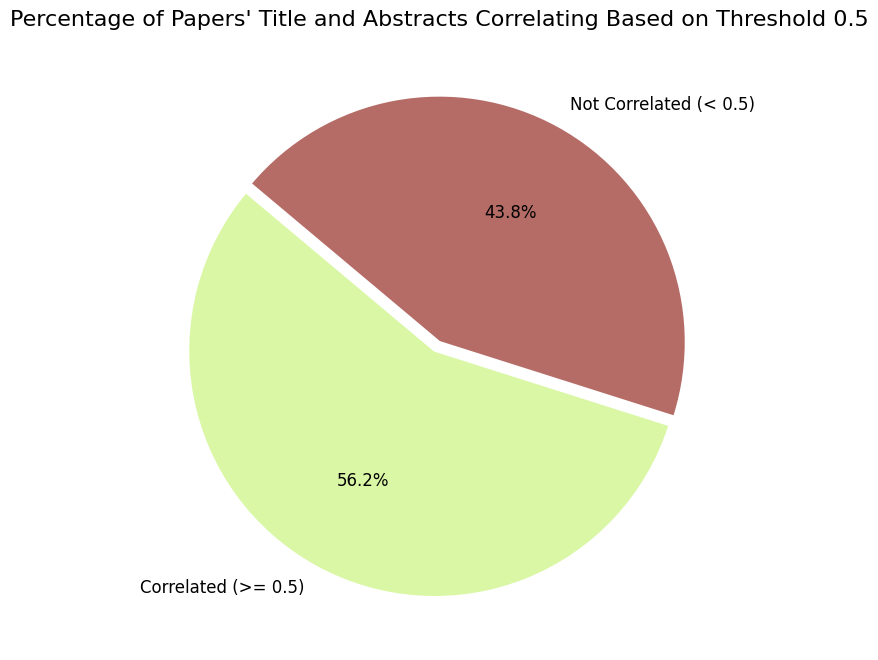

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced Pie Chart for Correlation Threshold
threshold = 0.5
correlated = (df_filtered["Similarity"] >= threshold).sum()
not_correlated = (df_filtered["Similarity"] < threshold).sum()

plt.figure(figsize=(10, 8))
colors = ["#DAF7A6", "#B56C67"]
explode = (0.04, 0)  # Explode correlated slice for emphasis
plt.pie(
    [correlated, not_correlated],
    labels=[f"Correlated (>= {threshold})", f"Not Correlated (< {threshold})"],
    autopct="%1.1f%%",
    colors=colors,
    explode=explode,
    startangle=140,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5},
    textprops={"fontsize": 12}
)
plt.title(f"Percentage of Papers' Title and Abstracts Correlating Based on Threshold {threshold}", fontsize=16)
print(f" Correlated -> {correlated} \n Not correlated -> {not_correlated} \n")
plt.show()

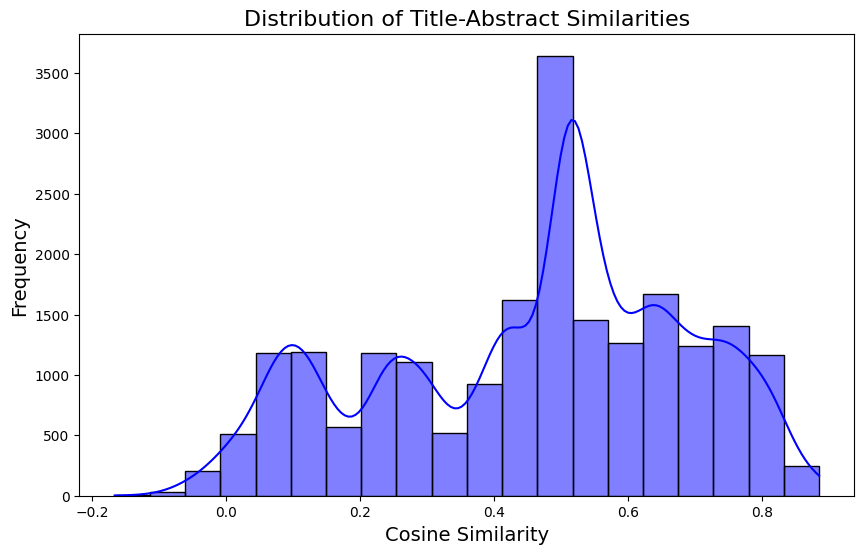

In [ ]:
# Visualization of Similarity Distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered["Similarity"], kde=True, bins=20, color="blue")
plt.title("Distribution of Title-Abstract Similarities", fontsize=16)
plt.xlabel("Cosine Similarity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

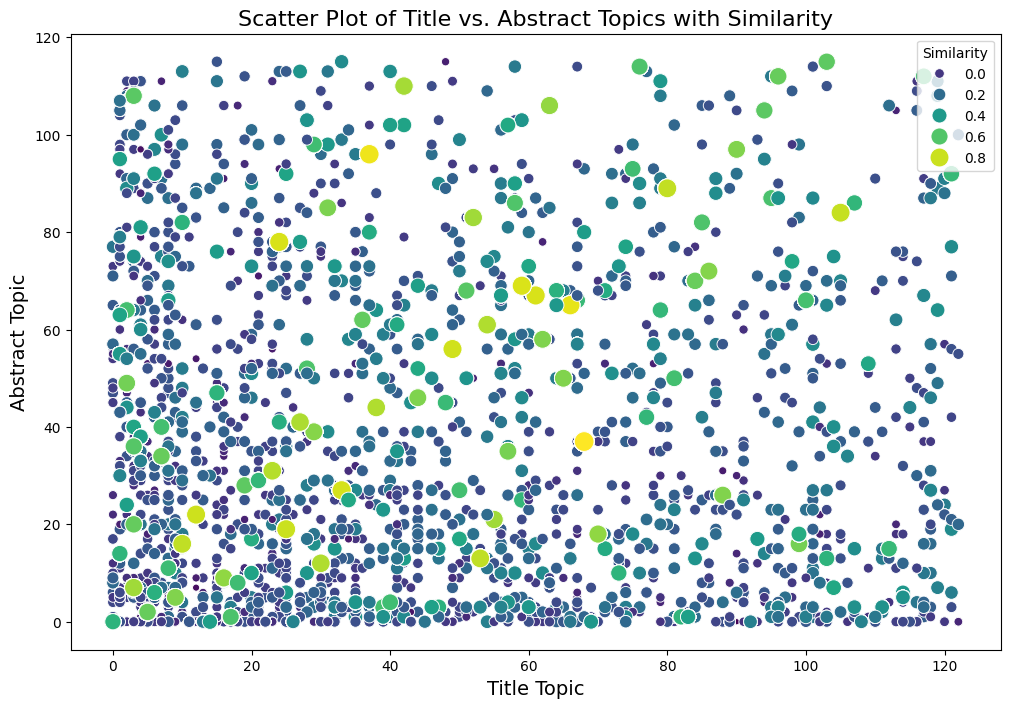

In [ ]:
# Scatter Plot of Similarities
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="Title Topic",
    y="Abstract Topic",
    size="Similarity",
    hue="Similarity",
    sizes=(20, 200),
    palette="viridis",
    data=df_filtered
)
plt.title("Scatter Plot of Title vs. Abstract Topics with Similarity", fontsize=16)
plt.xlabel("Title Topic", fontsize=14)
plt.ylabel("Abstract Topic", fontsize=14)
plt.legend(title="Similarity", fontsize=10)
plt.show()

## Potential concerns
- Abstract Length vs. Title Length: The size of abstracts is significantly larger than that of titles, which inherently creates a bias. Abstracts provide a more comprehensive description, whereas titles often summarize the key idea in a few words. This disparity may lead to less meaningful correlations between their topics.
- Ambiguity in Topic Assignment: Titles and abstracts might cover overlapping yet distinct themes. Assigning topics to such content can introduce variability in the correlation analysis.

## ✅ Conclusion
This analysis provides valuable insights into the relationship between topics in research paper titles and their abstracts.

### Key Takeaways:
- **Topic Discrepancies**: The results show that topic probabilities for titles and abstracts often differ, indicating that titles may not always fully capture the breadth or depth of the abstract's content. This suggests a potential gap in title informativeness, where titles may not always align perfectly with the topics discussed in the abstract.

- **Correlation Analysis**: The correlation analysis revealed that  11885  instances show a strong alignment between the topics in titles and abstracts, while 9256 instances exhibited a lack of correlation. This split provides a quantitative foundation for understanding the degree of alignment between these two sections.

- I**mproving Title-Abstract Coherence**: These findings suggest that many research papers could benefit from refining their titles to more accurately reflect the core topics and themes presented in the abstract. Researchers should consider focusing on more specific terms or phrases in the title that better encapsulate the key findings or topics in their work.



### Implications for Academic Writing:
- **Guidance for Title Creation**: Authors should aim for greater clarity and specificity in their titles to ensure they mirror the key topics and insights discussed in the abstract.
- **Future Research**: Further studies could explore how different academic fields and paper types influence the alignment between titles and abstracts. Additionally, studying the impact of title length and specificity on this alignment could offer deeper insights.

By addressing these gaps, researchers can improve the clarity and effectiveness of their paper titles, ultimately making their work more accessible and reflective of the research content.